# Swish-based classifier using cosine-annealed LR with restarts and data augmentation
- Swish activation, 4 layers, 100 neurons per layer
- LR using cosine-annealing with restarts and cycle multiplicity of 2
- Data is augmentaed via phi rotations, and transvers and longitudinal flips
- Validation score use ensemble of 10 models weighted by loss

### Import modules

In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2
from __future__ import division
import sys
import os
sys.path.append('../')
from modules.basics import *
from modules.class_basics import *
from modules.data_import import *

/home/giles/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


## Options

In [2]:
with open(DATA_PATH/'feats.pkl', 'rb') as fin:
    train_feats = pickle.load(fin)

In [14]:
n_models = 10
patience = 2
max_epochs = 200

ensemble_size = 10
ensemble_mode = 'loss'

compile_args = {'loss':'binary_crossentropy', 'optimizer':'adam', 'do':0.15}
train_params = {'epochs' : 1, 'batch_size' : 256, 'verbose' : 0}
model_params = {'version':'modelSwish', 'n_in':len(train_feats), 'compile_args':compile_args, 'mode':'classifier'}

print ("\nTraining on", len(train_feats), "features:", [var for var in train_feats])


Training on 30 features: ['DER_mass_MMC', 'DER_mass_transverse_met_lep', 'DER_mass_vis', 'DER_pt_h', 'DER_deltaeta_jet_jet', 'DER_mass_jet_jet', 'DER_prodeta_jet_jet', 'DER_deltar_tau_lep', 'DER_pt_tot', 'DER_sum_pt', 'DER_pt_ratio_lep_tau', 'DER_met_phi_centrality', 'DER_lep_eta_centrality', 'PRI_met_pt', 'PRI_met_sumet', 'PRI_jet_num', 'PRI_jet_all_pt', 'PRI_tau_px', 'PRI_tau_py', 'PRI_tau_pz', 'PRI_lep_px', 'PRI_lep_pz', 'PRI_jet_leading_px', 'PRI_jet_leading_py', 'PRI_jet_leading_pz', 'PRI_jet_subleading_px', 'PRI_jet_subleading_py', 'PRI_jet_subleading_pz', 'PRI_met_px', 'PRI_met_py']


## Import data

In [4]:
with open(DATA_PATH/'input_pipe.pkl', 'rb') as fin:
    input_pipe = pickle.load(fin)

In [5]:
train_fy = FoldYielder(h5py.File(DATA_PATH/'train.hdf5', "r+"))

def reconvert_event(in_data):
    move_to_cartesian(in_data, 'PRI_tau', drop=False)
    move_to_cartesian(in_data, 'PRI_lep', drop=False)
    move_to_cartesian(in_data, 'PRI_jet_leading', drop=False)
    move_to_cartesian(in_data, 'PRI_jet_subleading', drop=False)
    move_to_cartesian(in_data, 'PRI_met', z=False)

id = 19
nom = pd.DataFrame(train_fy.get_fold(0)['inputs'], columns=train_feats)[id:id+1]

z_flip = nom.copy()
z_flip_event(z_flip)
reconvert_event(z_flip)

rot = nom.copy()
rotate_event(rot)
reconvert_event(rot)

rot_y = nom.copy()
rotate_event(rot_y)
y_flip_event(rot_y)
reconvert_event(rot_y)

rot_yz = nom.copy()
rotate_event(rot_yz)
y_flip_event(rot_yz)
z_flip_event(rot_yz)
reconvert_event(rot_yz)

comp_events([nom, rot, rot_y, rot_yz])

/home/giles/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


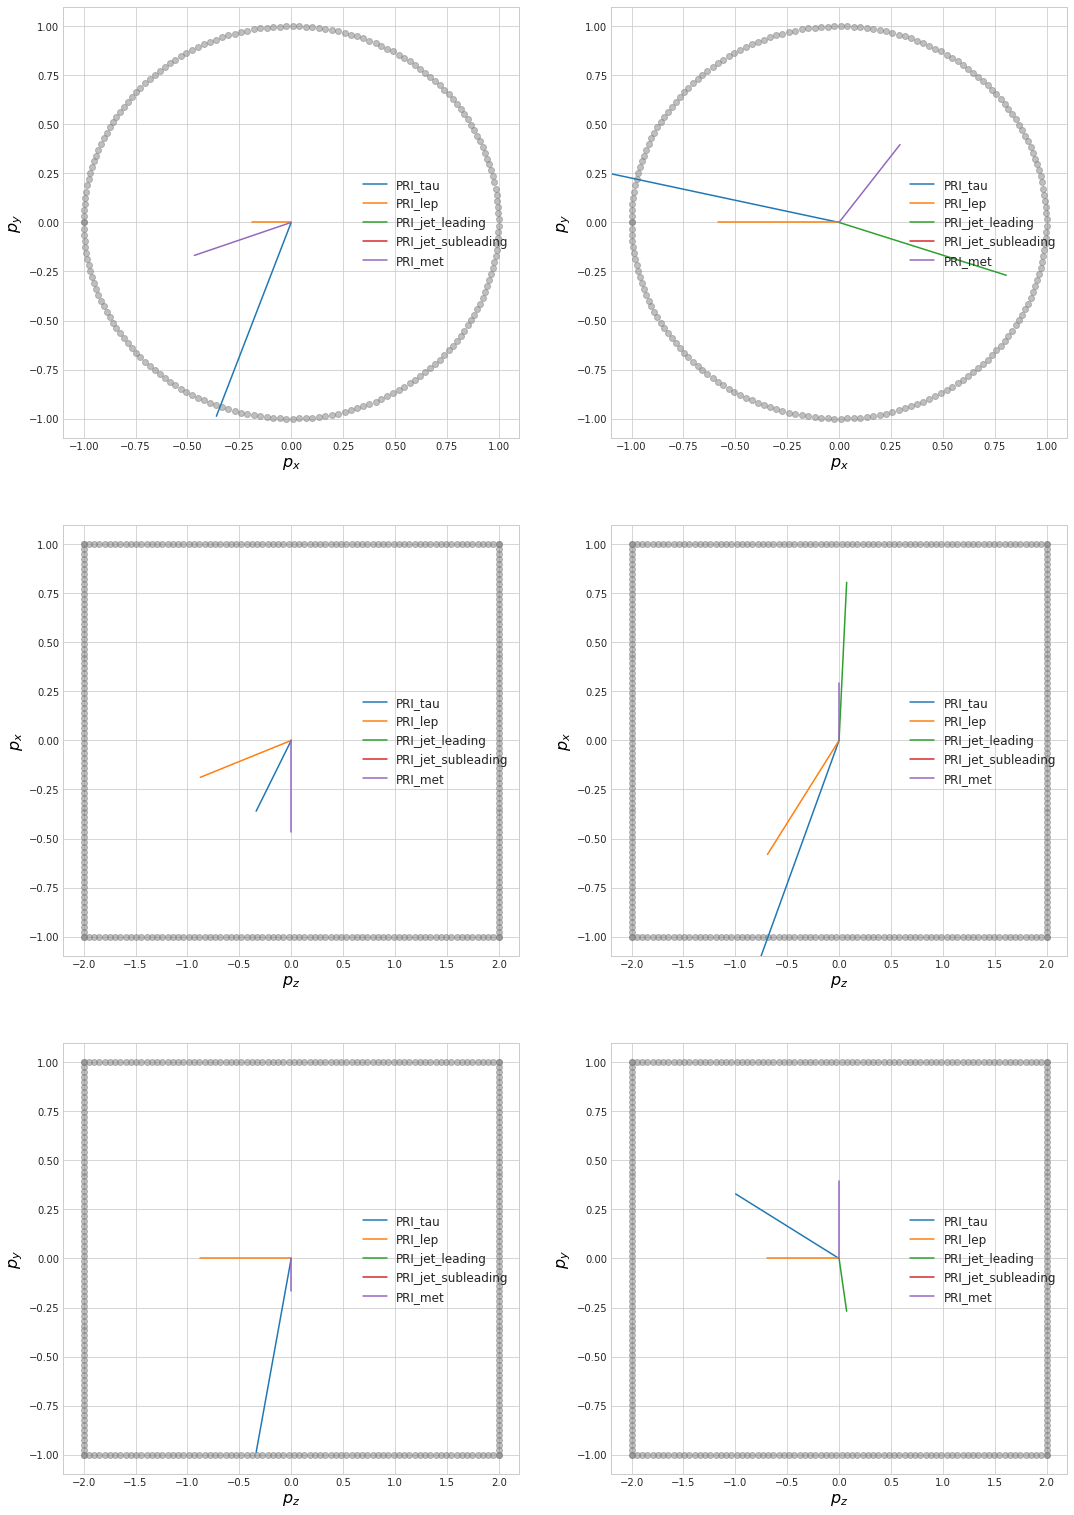

In [6]:
id = 0
pd.DataFrame(train_fy.get_fold(0)['inputs'], columns=train_feats)[id:id+1]
comp_events([pd.DataFrame(train_fy.get_fold(0)['inputs'], columns=train_feats)[id:id+1],
             pd.DataFrame(train_fy.get_fold(0)['inputs'], columns=train_feats)[id+1:id+2]])

## Determine LR

2 classes found, running in binary mode



/home/giles/anaconda3/lib/python3.6/site-packages/seaborn/timeseries.py:183: UserWarning: The tsplot function is deprecated and will be removed or replaced (in a substantially altered version) in a future release.
  warnings.warn(msg, UserWarning)
No handles with labels found to put in legend.



______________________________________
Training finished
Cross-validation took 31.474s 


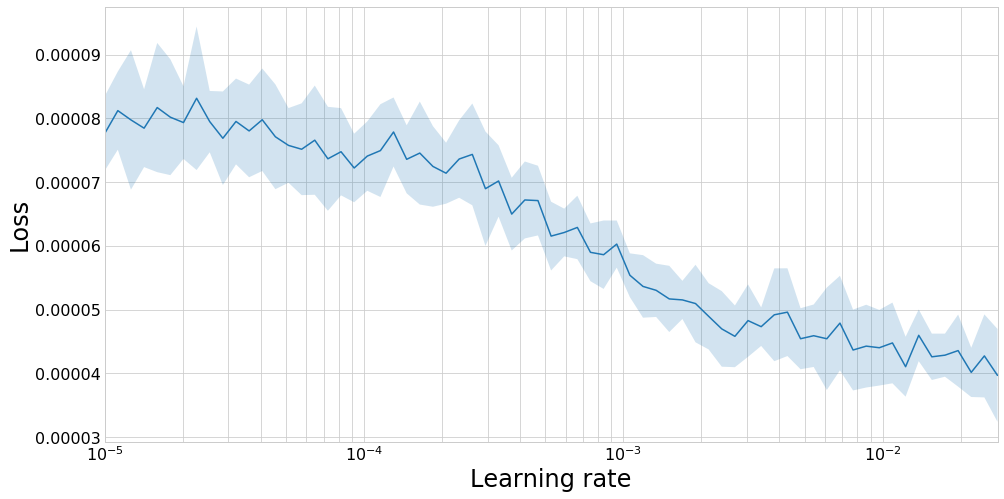

______________________________________



In [15]:
lr_finder = fold_lr_find(train_fy, get_model, model_params, train_params,
                         lr_bounds=[1e-5,1e-1], train_on_weights=True, verbose=0)

## Train classifier

In [16]:
model_gen_params = {**model_params, 'compile_args':{**compile_args, 'lr':3e-3}}
use_callbacks = {'CosAnnealLR':{'cycle_mult':2, 'reverse':False, 'redux_decay':True}}
ams_args = {'n_total':250000, 'br':10, 'delta_b':0}
plots = ['history', 'lr']

In [17]:
model_gen_params

{'version': 'modelSwish',
 'n_in': 30,
 'compile_args': {'loss': 'binary_crossentropy',
  'optimizer': 'adam',
  'do': 0.15,
  'lr': 0.003,
  'amsgrad': False,
  'beta_1': 0.9},
 'mode': 'classifier'}

Training using weights
Training model 1 / 10
Using cosine LR annealing
2 classes found, running in binary mode



/home/giles/anaconda3/lib/python3.6/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.631017). Check your callbacks.
  % delta_t_median)
/home/giles/anaconda3/lib/python3.6/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.315945). Check your callbacks.
  % delta_t_median)


1 New best found: 3.727011515261342e-05
2 New best found: 3.4964422102832965e-05
3 New best found: 3.448764498974382e-05
4 New best found: 3.421766306239135e-05
5 New best found: 3.4115907340347476e-05
6 New best found: 3.354930947425013e-05
7 New best found: 3.3452861796582865e-05
12 New best found: 3.321503416510866e-05
13 New best found: 3.3013532776256466e-05
14 New best found: 3.2889853380685416e-05
22 New best found: 3.288306968604396e-05
23 New best found: 3.276556287225361e-05
24 New best found: 3.262818560403798e-05
26 New best found: 3.2611234439785344e-05
28 New best found: 3.255814849421077e-05
29 New best found: 3.255028365408021e-05
31 New best found: 3.2547365746226726e-05
47 New best found: 3.2467748224721655e-05
49 New best found: 3.240602368049834e-05
51 New best found: 3.2291695601579456e-05
53 New best found: 3.226563632667052e-05
55 New best found: 3.215773608638983e-05
59 New best found: 3.212027182882426e-05
60 New best found: 3.211542204635275e-05
102 New best f

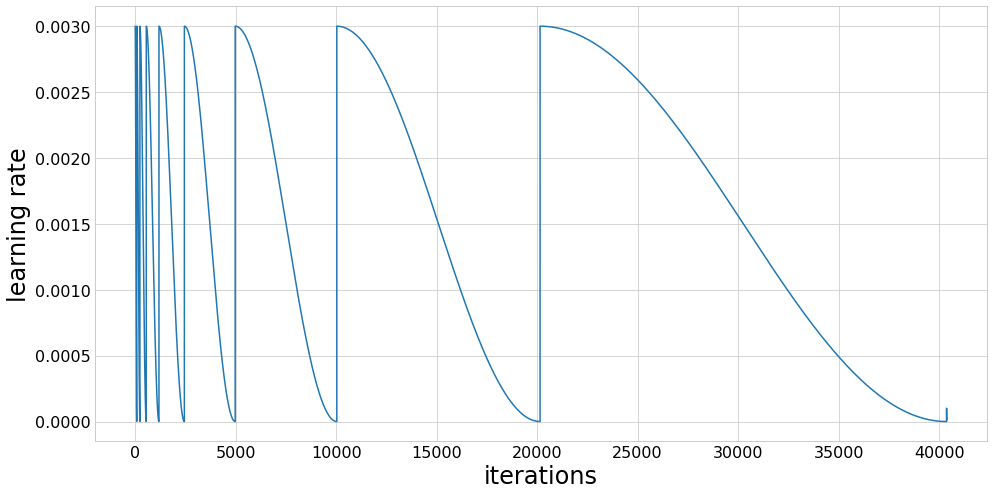

Fold took 647.255s

Training model 2 / 10
Using cosine LR annealing


/home/giles/anaconda3/lib/python3.6/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.690879). Check your callbacks.
  % delta_t_median)
/home/giles/anaconda3/lib/python3.6/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.345869). Check your callbacks.
  % delta_t_median)


1 New best found: 3.71403733434317e-05
2 New best found: 3.574157492175361e-05
3 New best found: 3.4909819754756474e-05
4 New best found: 3.456960486840806e-05
5 New best found: 3.409006189982845e-05
6 New best found: 3.3668533263934756e-05
7 New best found: 3.3590555890002204e-05
9 New best found: 3.3230340442218055e-05
12 New best found: 3.3046965273543674e-05
13 New best found: 3.287293567847973e-05
14 New best found: 3.2817029961339e-05
15 New best found: 3.2806132641618064e-05
21 New best found: 3.273095903693021e-05
22 New best found: 3.270935113957694e-05
23 New best found: 3.254510580903733e-05
26 New best found: 3.246384248683968e-05
27 New best found: 3.232786588007746e-05
28 New best found: 3.2283953851264184e-05
46 New best found: 3.209660792243066e-05
52 New best found: 3.206376838443332e-05
53 New best found: 3.205253067550135e-05
55 New best found: 3.198444945488791e-05
58 New best found: 3.195194512776661e-05
59 New best found: 3.193563182571133e-05
61 New best found: 3

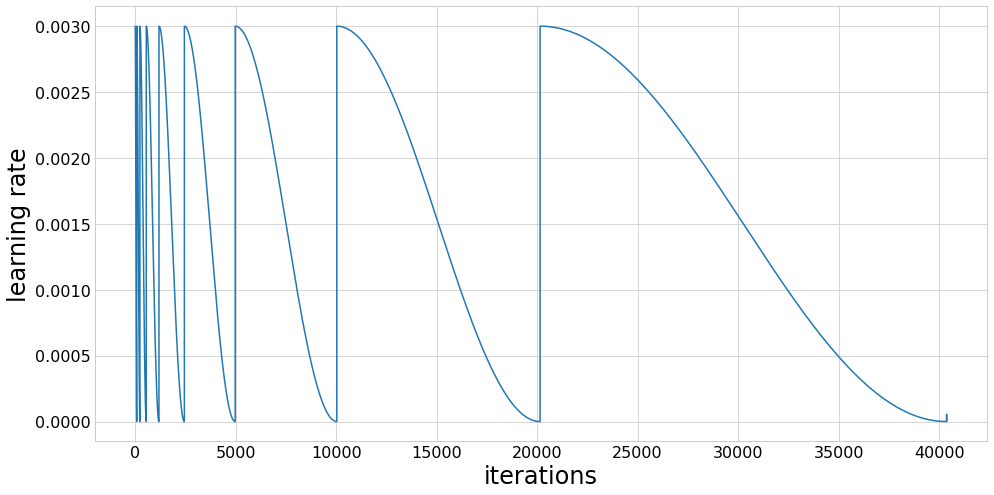

Fold took 659.612s

Training model 3 / 10
Using cosine LR annealing


/home/giles/anaconda3/lib/python3.6/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.711172). Check your callbacks.
  % delta_t_median)
/home/giles/anaconda3/lib/python3.6/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.356085). Check your callbacks.
  % delta_t_median)


1 New best found: 3.7402664301603606e-05
2 New best found: 3.57415133278436e-05
3 New best found: 3.463187346021919e-05
4 New best found: 3.442097156450811e-05
5 New best found: 3.4398561716379206e-05
6 New best found: 3.382884532260443e-05
7 New best found: 3.364779018013687e-05
10 New best found: 3.32925843327572e-05
12 New best found: 3.306437493268748e-05
13 New best found: 3.303119599204695e-05
14 New best found: 3.2886575791075304e-05
15 New best found: 3.286422888640111e-05
25 New best found: 3.261518856921038e-05
26 New best found: 3.2577500427056446e-05
27 New best found: 3.246969196879354e-05
28 New best found: 3.246278984201587e-05
31 New best found: 3.2460964365953674e-05
46 New best found: 3.237545296155921e-05
53 New best found: 3.235549717871302e-05
54 New best found: 3.227062811323986e-05
57 New best found: 3.22124520042752e-05
59 New best found: 3.219052117021105e-05
60 New best found: 3.217576199296872e-05
61 New best found: 3.217381990712501e-05
63 New best found: 3.

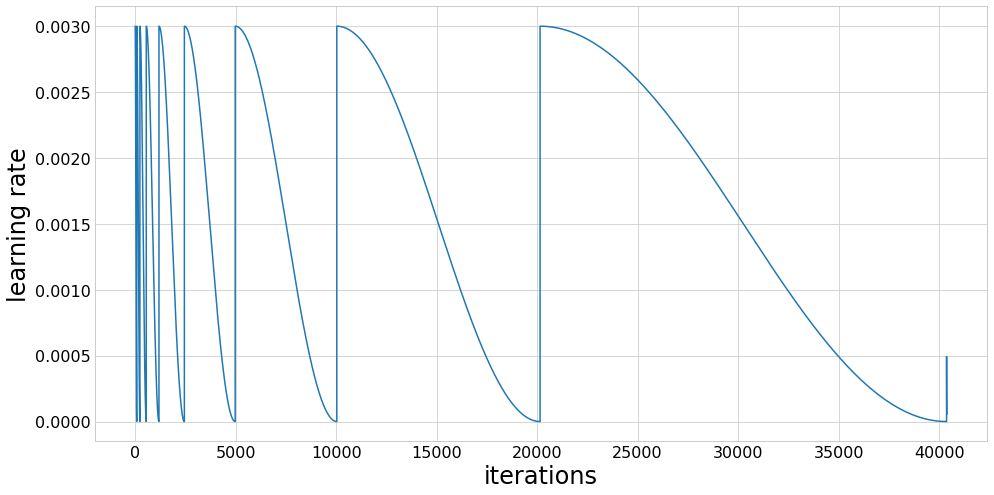

Fold took 675.299s

Training model 4 / 10
Using cosine LR annealing


/home/giles/anaconda3/lib/python3.6/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.769937). Check your callbacks.
  % delta_t_median)
/home/giles/anaconda3/lib/python3.6/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.385462). Check your callbacks.
  % delta_t_median)


1 New best found: 3.6823141105455e-05
2 New best found: 3.49528186531969e-05
3 New best found: 3.426687599303582e-05
5 New best found: 3.3336409772977676e-05
6 New best found: 3.3039472359693006e-05
7 New best found: 3.293859628538017e-05
11 New best found: 3.271348483385919e-05
12 New best found: 3.256758993304879e-05
13 New best found: 3.251884926690635e-05
14 New best found: 3.239825710048357e-05
15 New best found: 3.2373124617273826e-05
25 New best found: 3.2138804311117935e-05
27 New best found: 3.204122524530644e-05
29 New best found: 3.2018010371447113e-05
30 New best found: 3.200895988358252e-05
31 New best found: 3.200484531193965e-05
51 New best found: 3.197631004112436e-05
52 New best found: 3.186352301640501e-05
61 New best found: 3.18601187685011e-05
62 New best found: 3.185714050323561e-05
63 New best found: 3.185668980769419e-05
102 New best found: 3.185274749190966e-05
107 New best found: 3.1824013756667035e-05
111 New best found: 3.181175265935769e-05
115 New best foun

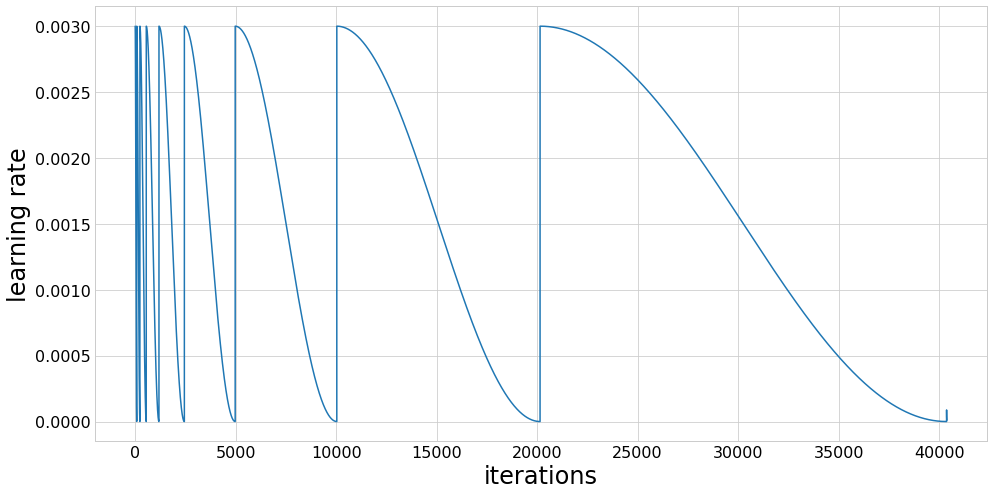

Fold took 691.106s

Training model 5 / 10
Using cosine LR annealing


/home/giles/anaconda3/lib/python3.6/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.765613). Check your callbacks.
  % delta_t_median)
/home/giles/anaconda3/lib/python3.6/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.383290). Check your callbacks.
  % delta_t_median)


1 New best found: 3.718353653724919e-05
2 New best found: 3.468068937150853e-05
3 New best found: 3.3913683702283894e-05
4 New best found: 3.380317982088258e-05
5 New best found: 3.3172083577192584e-05
6 New best found: 3.2881116413765596e-05
7 New best found: 3.28192542468814e-05
9 New best found: 3.270446996170918e-05
10 New best found: 3.269651107312314e-05
11 New best found: 3.2401187405153255e-05
12 New best found: 3.230455562109162e-05
13 New best found: 3.222491795668236e-05
14 New best found: 3.210770262168688e-05
15 New best found: 3.209386169947351e-05
23 New best found: 3.198700528420194e-05
24 New best found: 3.190801203292037e-05
25 New best found: 3.1774820149267935e-05
26 New best found: 3.173131075287244e-05
27 New best found: 3.170709405342653e-05
29 New best found: 3.165409796223577e-05
30 New best found: 3.164381030216529e-05
31 New best found: 3.164378809465038e-05
51 New best found: 3.1643261968769155e-05
52 New best found: 3.149465551141236e-05
53 New best found: 

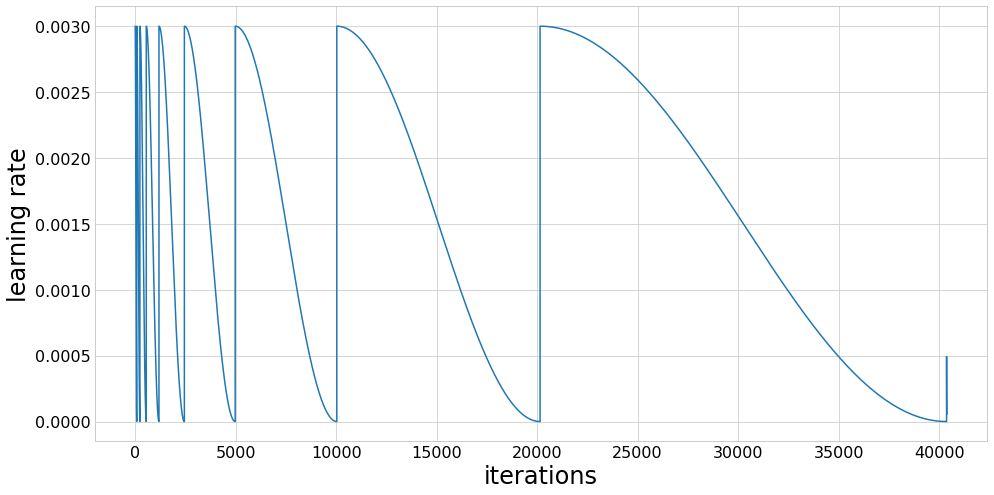

Fold took 704.768s

Training model 6 / 10
Using cosine LR annealing


/home/giles/anaconda3/lib/python3.6/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.834784). Check your callbacks.
  % delta_t_median)
/home/giles/anaconda3/lib/python3.6/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.417901). Check your callbacks.
  % delta_t_median)


1 New best found: 3.788813231221866e-05
2 New best found: 3.473572770017199e-05
3 New best found: 3.451434899470769e-05
4 New best found: 3.4276308817788956e-05
5 New best found: 3.3592618610418864e-05
6 New best found: 3.3281779162643946e-05
7 New best found: 3.3166395814623686e-05
9 New best found: 3.302700712811202e-05
11 New best found: 3.275365243316628e-05
12 New best found: 3.2567369048047115e-05
13 New best found: 3.246012713498203e-05
14 New best found: 3.230537617055234e-05
15 New best found: 3.2294989103684203e-05
23 New best found: 3.22185772456578e-05
25 New best found: 3.215317993744975e-05
26 New best found: 3.1957825160498035e-05
27 New best found: 3.19468759400479e-05
28 New best found: 3.189442075963598e-05
29 New best found: 3.185254607742536e-05
30 New best found: 3.184710627101595e-05
31 New best found: 3.184615823265631e-05
48 New best found: 3.183482284657657e-05
50 New best found: 3.178297700069379e-05
51 New best found: 3.175002063362626e-05
52 New best found: 

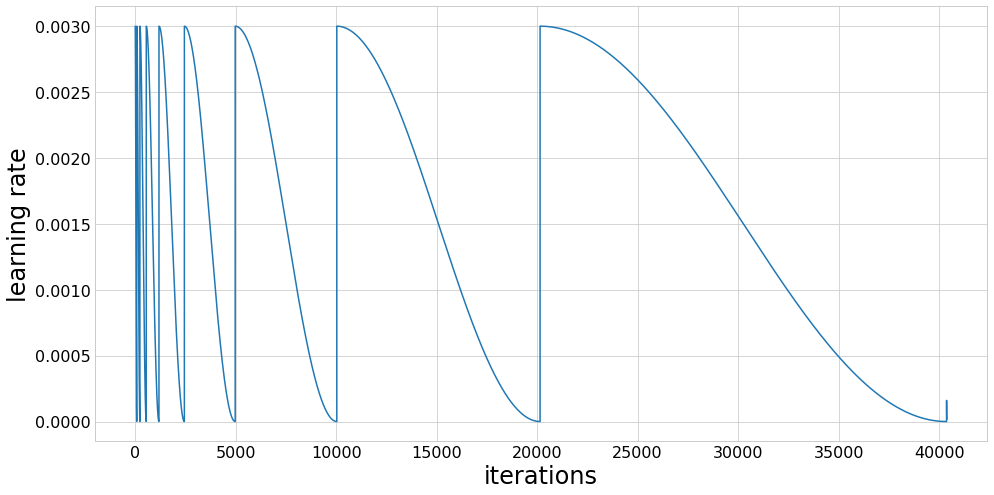

Fold took 710.832s

Training model 7 / 10
Using cosine LR annealing


/home/giles/anaconda3/lib/python3.6/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.860465). Check your callbacks.
  % delta_t_median)
/home/giles/anaconda3/lib/python3.6/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.430741). Check your callbacks.
  % delta_t_median)


1 New best found: 3.704414728860298e-05
2 New best found: 3.47677911079429e-05
3 New best found: 3.436172189500331e-05
4 New best found: 3.432445812864764e-05
5 New best found: 3.386895455763093e-05
6 New best found: 3.318229222731406e-05
7 New best found: 3.3066815987482564e-05
9 New best found: 3.302214451705956e-05
11 New best found: 3.27718949753221e-05
12 New best found: 3.263214288924492e-05
13 New best found: 3.24849307484744e-05
14 New best found: 3.239898864081903e-05
24 New best found: 3.2377701079584874e-05
25 New best found: 3.217903168244878e-05
26 New best found: 3.209756955043558e-05
29 New best found: 3.2073993491176556e-05
31 New best found: 3.2069044389973055e-05
52 New best found: 3.198573767683689e-05
53 New best found: 3.189990776429514e-05
56 New best found: 3.1880863406694556e-05
59 New best found: 3.186785133634219e-05
61 New best found: 3.184532474457015e-05
62 New best found: 3.1834342025048536e-05
63 New best found: 3.18341893667198e-05
92 New best found: 3.1

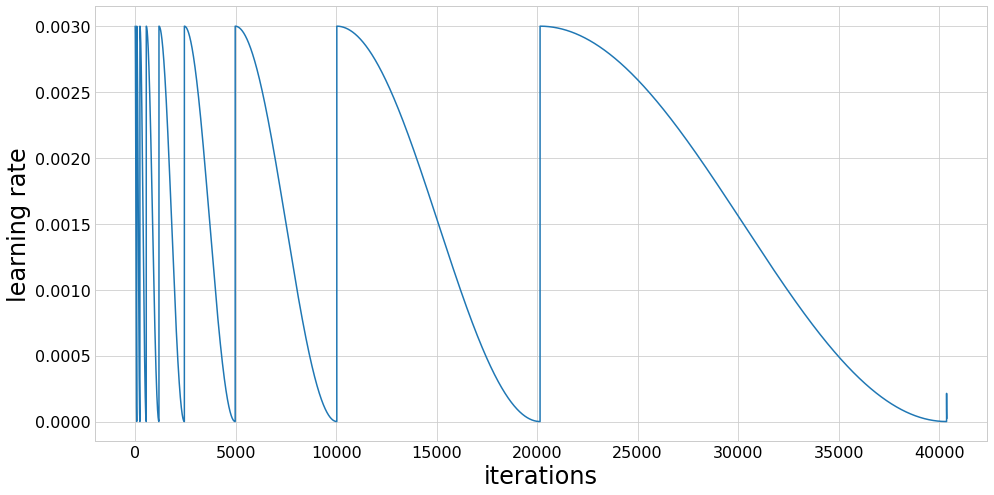

Fold took 721.167s

Training model 8 / 10
Using cosine LR annealing


/home/giles/anaconda3/lib/python3.6/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.892829). Check your callbacks.
  % delta_t_median)
/home/giles/anaconda3/lib/python3.6/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.446927). Check your callbacks.
  % delta_t_median)


1 New best found: 3.8780285729444585e-05
2 New best found: 3.6400667343696116e-05
3 New best found: 3.56998940667836e-05
4 New best found: 3.539106767129852e-05
5 New best found: 3.531288488738937e-05
6 New best found: 3.431380581896519e-05
7 New best found: 3.4195393898698964e-05
9 New best found: 3.419483730322099e-05
10 New best found: 3.4060694398067424e-05
11 New best found: 3.385133878400666e-05
12 New best found: 3.356849084739224e-05
13 New best found: 3.337610462185694e-05
14 New best found: 3.3333341313118584e-05
15 New best found: 3.329346677273861e-05
23 New best found: 3.311449967732187e-05
25 New best found: 3.297746223615832e-05
27 New best found: 3.284883976957644e-05
29 New best found: 3.281832682259847e-05
30 New best found: 3.280626795021817e-05
51 New best found: 3.278331644687569e-05
54 New best found: 3.264414704462979e-05
56 New best found: 3.258536650682799e-05
60 New best found: 3.258500550946337e-05
61 New best found: 3.2569934707862555e-05
62 New best found: 

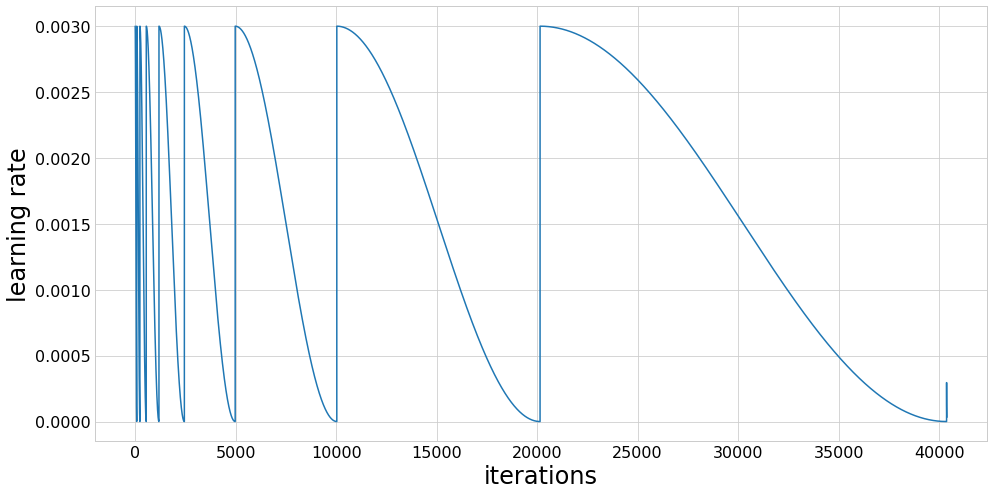

Fold took 734.852s

Training model 9 / 10
Using cosine LR annealing


/home/giles/anaconda3/lib/python3.6/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.938113). Check your callbacks.
  % delta_t_median)
/home/giles/anaconda3/lib/python3.6/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.469531). Check your callbacks.
  % delta_t_median)


1 New best found: 3.820219527260633e-05
2 New best found: 3.508098521560896e-05
3 New best found: 3.455087430484127e-05
4 New best found: 3.4376652511127756e-05
5 New best found: 3.394350026064785e-05
6 New best found: 3.3373340529215056e-05
7 New best found: 3.334953184676124e-05
10 New best found: 3.3071081789967135e-05
11 New best found: 3.3020064805168656e-05
12 New best found: 3.263810576972901e-05
13 New best found: 3.252090856694849e-05
14 New best found: 3.250053016308812e-05
15 New best found: 3.2473736359679604e-05
23 New best found: 3.235094123519957e-05
26 New best found: 3.229325607098872e-05
27 New best found: 3.217973454447929e-05
28 New best found: 3.2157173135783526e-05
29 New best found: 3.21343210474879e-05
30 New best found: 3.209977473161416e-05
31 New best found: 3.209469085995806e-05
49 New best found: 3.203152296555345e-05
53 New best found: 3.193117135524517e-05
55 New best found: 3.1863746583258035e-05
56 New best found: 3.1811025939532556e-05
58 New best foun

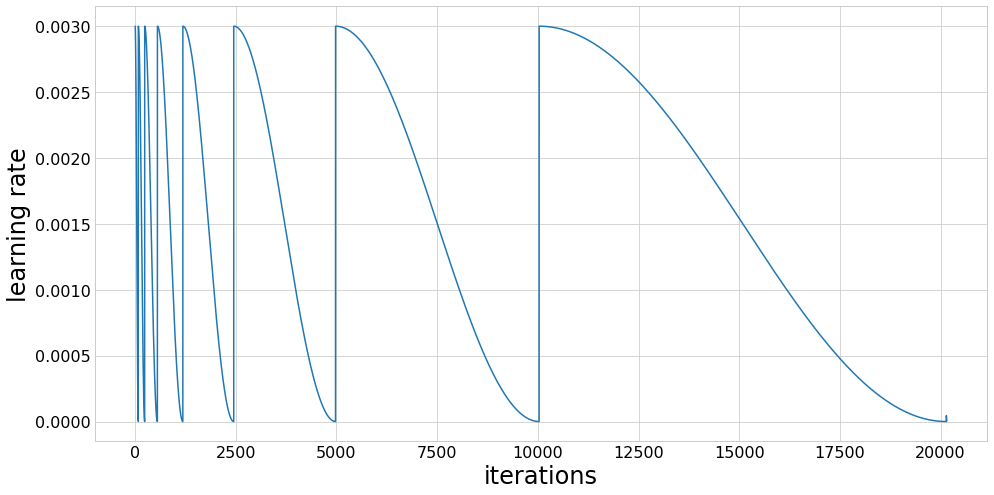

Fold took 387.274s

Training model 10 / 10
Using cosine LR annealing


/home/giles/anaconda3/lib/python3.6/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.957162). Check your callbacks.
  % delta_t_median)
/home/giles/anaconda3/lib/python3.6/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.479114). Check your callbacks.
  % delta_t_median)


1 New best found: 3.71866973786382e-05
2 New best found: 3.4783685512957165e-05
3 New best found: 3.4368262795032934e-05
4 New best found: 3.415429138840409e-05
5 New best found: 3.3271427324507384e-05
6 New best found: 3.293121910101036e-05
7 New best found: 3.2837925286003156e-05
10 New best found: 3.2718021210166626e-05
12 New best found: 3.240938033850398e-05
13 New best found: 3.2245613150735155e-05
14 New best found: 3.213192098555737e-05
15 New best found: 3.2126083623734304e-05
25 New best found: 3.174146158635267e-05
26 New best found: 3.165263056289405e-05
27 New best found: 3.1636686650745106e-05
28 New best found: 3.162374950479716e-05
29 New best found: 3.156894741623546e-05
30 New best found: 3.1553752218314914e-05
31 New best found: 3.1550541550677736e-05
50 New best found: 3.14625020720996e-05
54 New best found: 3.136611224254011e-05
55 New best found: 3.1330341415741713e-05
56 New best found: 3.132884873120929e-05
59 New best found: 3.132489169438486e-05
60 New best fo

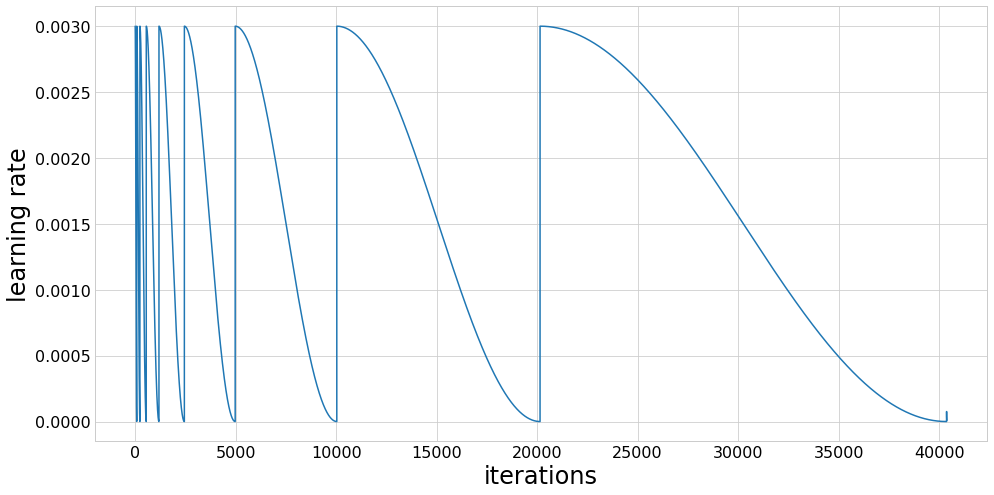

Fold took 758.516s


______________________________________
Training finished
Cross-validation took 6697.575s 


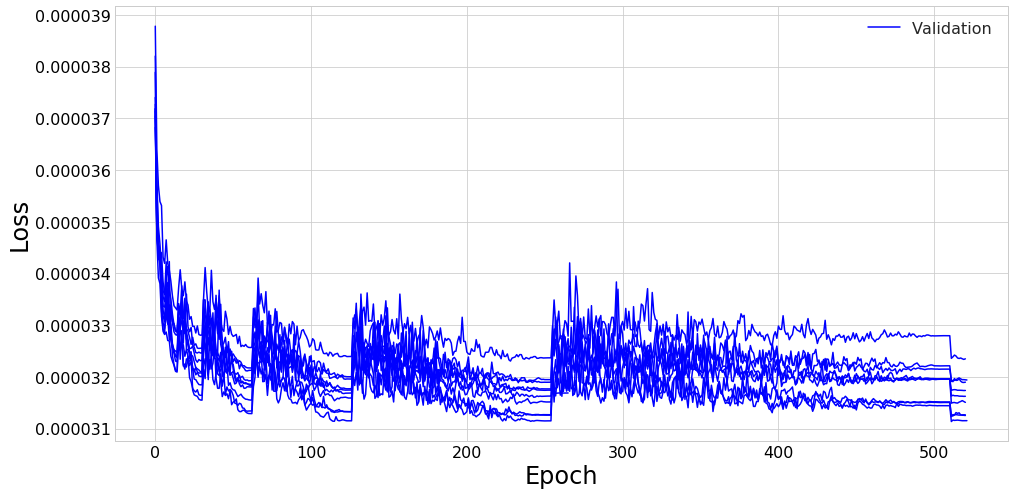

Mean loss = 3.16e-05 +- 1e-07
Mean wAUC = 0.0627 +- 0.0004
Mean AUC = 0.0977 +- 0.0005
Mean AMS = 4.0 +- 0.1
Mean cut = 0.961 +- 0.007
______________________________________



<Figure size 432x288 with 0 Axes>

In [18]:
results, histories = fold_train_model(train_fy, n_models,
                                      model_gen_params=model_gen_params,
                                      train_params=train_params, train_on_weights=True,
                                      use_callbacks=use_callbacks, ams_args=ams_args,
                                      max_epochs=max_epochs, patience=patience,
                                      verbose=1, plots=plots)

## Construct ensemble

In [19]:
with open('train_weights/resultsFile.pkl', 'rb') as fin:   
    results = pickle.load(fin)

In [20]:
ensemble, weights = assemble_ensemble(results, ensemble_size, ensemble_mode, compile_args)

Choosing ensemble by loss
Model 0 is 9 with loss = 3.113727980162366e-05
Model 1 is 4 with loss = 3.122912001183878e-05
Model 2 is 5 with loss = 3.124211761169136e-05
Model 3 is 6 with loss = 3.1473832930110926e-05
Model 4 is 1 with loss = 3.160610316498089e-05
Model 5 is 8 with loss = 3.1673703975684475e-05
Model 6 is 3 with loss = 3.17211680326087e-05
Model 7 is 2 with loss = 3.1888053485344893e-05
Model 8 is 0 with loss = 3.1910754760788703e-05
Model 9 is 7 with loss = 3.230604389100335e-05


## Response on validation data without TTA

In [21]:
val_fy = FoldYielder(h5py.File(DATA_PATH/'val.hdf5', "r+"))

In [22]:
fold_ensemble_predict(ensemble, weights, val_fy, ensemble_size=ensemble_size, verbose=1)

Predicting fold 1 out of 10
Prediction took 0.0033185933601111175s per sample

Predicting fold 2 out of 10
Prediction took 0.0005332099549472333s per sample

Predicting fold 3 out of 10
Prediction took 0.0005337585672736168s per sample

Predicting fold 4 out of 10
Prediction took 0.0005383873172104358s per sample

Predicting fold 5 out of 10
Prediction took 0.0005343502789735794s per sample

Predicting fold 6 out of 10
Prediction took 0.000540153581649065s per sample

Predicting fold 7 out of 10
Prediction took 0.0005370534010231495s per sample

Predicting fold 8 out of 10
Prediction took 0.0005396239094436169s per sample

Predicting fold 9 out of 10
Prediction took 0.0005383444182574749s per sample

Predicting fold 10 out of 10
Prediction took 0.0005324433989822864s per sample



In [23]:
val_df = convert_to_df(val_fy.source)

50000 candidates loaded


In [24]:
print('Testing ROC AUC: unweighted {}, weighted {}'.format(roc_auc_score(val_df.gen_target, val_df.pred_class),
                                                           roc_auc_score(val_df.gen_target, val_df.pred_class, sample_weight=val_df.gen_weight)))

Testing ROC AUC: unweighted 0.9037643906925473, weighted 0.9363409940324532


Best cut at 0.9640064610017313 corresponds to AMS of 3.803803119810259
Maximum AMS for data is 3.8898754340315014 at cut of 0.9646604657173157
CPU times: user 27.8 s, sys: 925 µs, total: 27.8 s
Wall time: 27.8 s


/home/giles/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


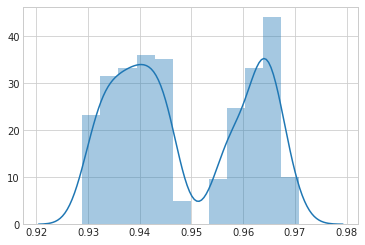

In [25]:
%%time
cut_kde = kde_optimise_cut(val_df, top_perc=0.05, br=10, w_factor=250000/50000)

Mean cut at 0.94879425 corresponds to AMS of 3.7334914558954204
Maximum AMS for data is 3.8898754340315014 at cut of 0.9646604657173157
CPU times: user 92.8 ms, sys: 32.2 ms, total: 125 ms
Wall time: 83 ms


/home/giles/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


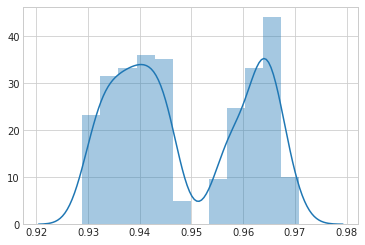

In [26]:
%%time
cut_mean = mean_optimise_cut(val_df, top_perc=0.05, br=10, w_factor=250000/50000)

# Test scoring - Without TTA

In [27]:
test_fy = FoldYielder(h5py.File(DATA_PATH/'testing.hdf5', "r+"))

In [28]:
%%time
fold_ensemble_predict(ensemble, weights, test_fy, ensemble_size=ensemble_size, verbose=1)

Predicting fold 1 out of 10
Prediction took 0.0005414552775296297s per sample

Predicting fold 2 out of 10
Prediction took 0.0005368404584174806s per sample

Predicting fold 3 out of 10
Prediction took 0.0005379347776147453s per sample

Predicting fold 4 out of 10
Prediction took 0.0005357136879116297s per sample

Predicting fold 5 out of 10
Prediction took 0.0005321781410751018s per sample

Predicting fold 6 out of 10
Prediction took 0.0005364804406396367s per sample

Predicting fold 7 out of 10
Prediction took 0.0005318893712691285s per sample

Predicting fold 8 out of 10
Prediction took 0.0005371740522032434s per sample

Predicting fold 9 out of 10
Prediction took 0.0005347640873356299s per sample

Predicting fold 10 out of 10
Prediction took 0.0005281751885332844s per sample

CPU times: user 5min 34s, sys: 5.43 s, total: 5min 40s
Wall time: 4min 54s


In [29]:
score_test_data(test_fy.source, cut_kde)

Public:Private AMS: 3.6002874210052496 : 3.709217774843114


(3.6002874210052496, 3.709217774843114)

In [30]:
score_test_data(test_fy.source, cut_mean)

Public:Private AMS: 3.780731246688145 : 3.7847682045566238


(3.780731246688145, 3.7847682045566238)

# Save/Load

In [ ]:
name = "weights/Swish_CLR_TTA"

In [ ]:
saveEnsemble(name, ensemble, weights, compile_args, overwrite=1)

In [ ]:
ensemble, weights, compile_args, _, _ = loadEnsemble(name)